# Physiology Lab - Fall 2019
# Oxygen Equilibrium of Hemocyanin Report

For this report, Dr. Beers only wants three graphs generated from the data obtained during lab. 

1. Plot % Oxygen Saturation (y-axis) as a funciton of oxygen partial pressure (x-axis). Determine the P<sub>50</sub> of the pigment under the experimental conditions.

In [2]:
hemodat = read.csv('OxygenEqHemo.csv')
hemodat$pH = as.factor(hemodat$pH)

In [3]:
hemodat$hill = log((hemodat$Percent.Oxy.Sat)*100/(100-(hemodat$Percent.Oxy.Sat*100)))
head(hemodat)

pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
7.3,0,0.007,764.25,24.195,610,0.000000,NA,NA
7.3,5,0.017,764.25,24.195,610,6.066025,0.03717472,-3.2542430
7.3,15,0.027,764.25,24.195,610,18.198074,0.07434944,-2.5217206
7.3,35,0.070,764.25,24.195,610,42.462172,0.23420074,-1.1847414
7.3,55,0.153,764.25,24.195,610,66.726270,0.54275093,0.1714223
7.3,65,0.194,764.25,24.195,610,78.858320,0.69516729,0.8243894


In [4]:
hem_73 = hemodat[hemodat$pH == '7.3',]
hem_68 = hemodat[hemodat$pH == '6.8',]
hem_78 = hemodat[hemodat$pH == '7.8',]
hem_73

pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
7.3,0,0.007,764.25,24.195,610,0.000000,NA,NA
7.3,5,0.017,764.25,24.195,610,6.066025,0.03717472,-3.2542430
7.3,15,0.027,764.25,24.195,610,18.198074,0.07434944,-2.5217206
7.3,35,0.070,764.25,24.195,610,42.462172,0.23420074,-1.1847414
7.3,55,0.153,764.25,24.195,610,66.726270,0.54275093,0.1714223
7.3,65,0.194,764.25,24.195,610,78.858320,0.69516729,0.8243894
7.3,70,0.201,764.25,24.195,610,84.924344,0.72118959,0.9503700
7.3,75,0.223,764.25,24.195,610,90.990369,0.80297398,1.4049865


In [22]:
require(nlme)
require(ggplot2)
require(ggpubr)

Loading required package: ggpubr

Loading required package: magrittr



Nonlinear regression model
  model: Percent.Oxy.Sat ~ SSlogis(PO2, Asym, xmid, scal)
   data: hem_73
   Asym    xmid    scal 
 0.9347 61.2645 17.4007 
 residual sum-of-squares: 0.0007583

Number of iterations to convergence: 0 
Achieved convergence tolerance: 4.584e-07

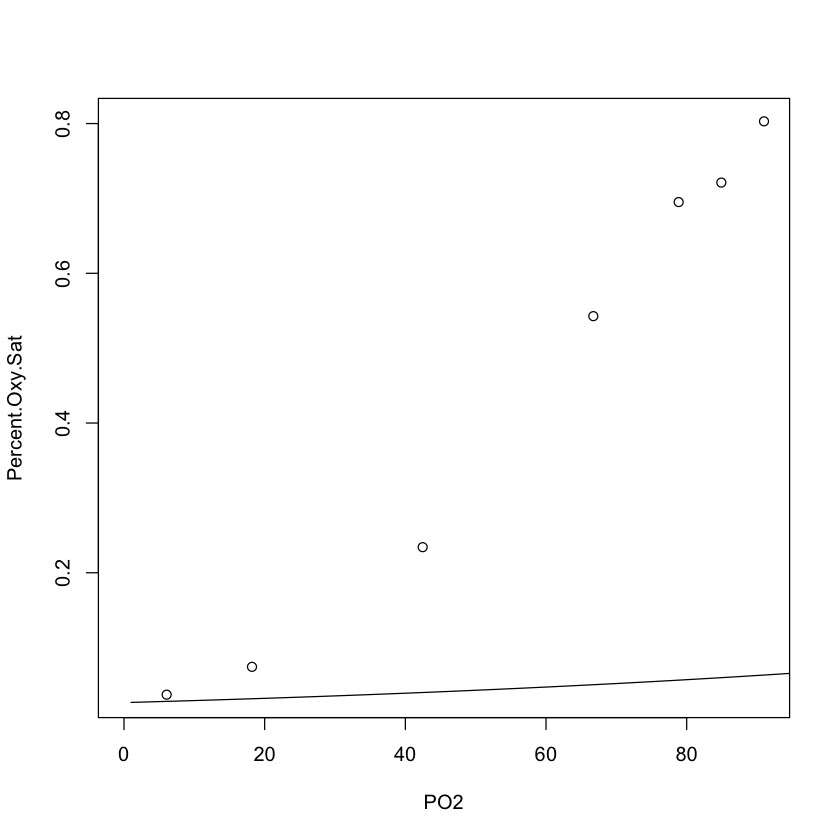

In [32]:
eq73 = nls(Percent.Oxy.Sat ~ SSlogis(PO2, Asym, xmid, scal), data = hem_73)
eq73
plot(Percent.Oxy.Sat~PO2, data = hem_73)
points(predict(eq73, newdata = data.frame(PO2 = 17.4*seq(0,100,0.01))), type = "l")

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_path).”


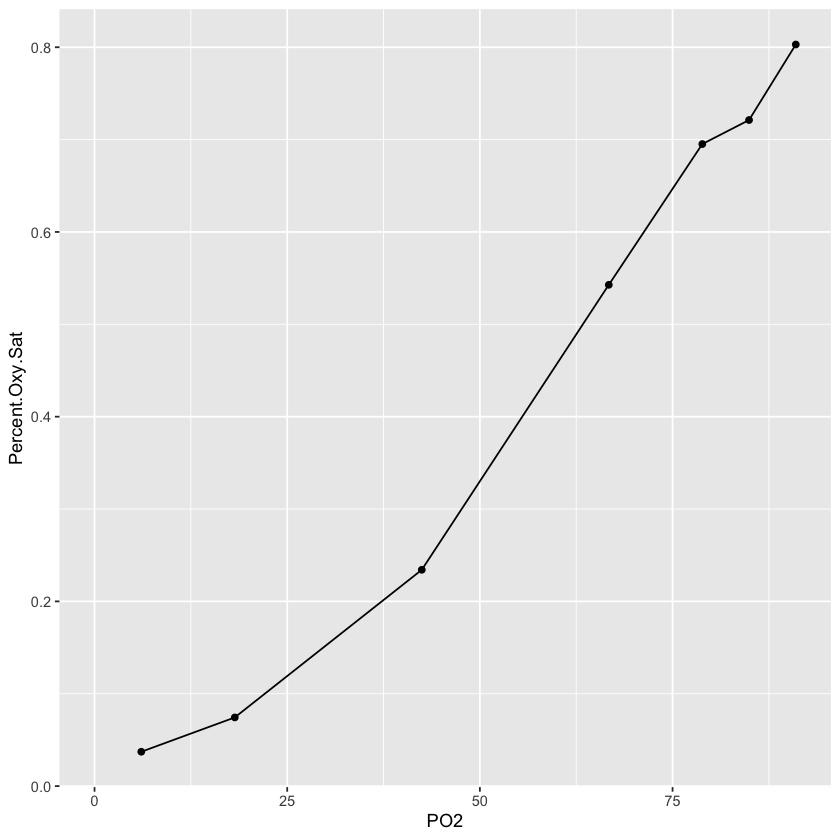

In [21]:
ggplot(hem_73, aes(PO2, Percent.Oxy.Sat)) +
    geom_point() +

2. Estimate the cooperativity of the hemocyanin (i.e. Create a Hill Plot). An estimate of cooperativity between hemocyanin subunits can bbe obtained by plotting the log of percent saturation ove rpercent unsaturation as a function of the log of Po<sub>2</sub> and measuring the slope of the line around P<sub>50</sub> (n or sometimes n<sub>50</sub>). This number is an indec of cooperativity. The higher the number, the grater the cooperativity.


Call:
lm(formula = hill ~ log(PO2), data = hem_73)

Residuals:
      2       3       4       5       6       7       8 
 0.5685 -0.6034 -0.7352 -0.1625  0.2009  0.1984  0.5334 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.9476     0.8784  -7.909 0.000520 ***
log(PO2)      1.7335     0.2295   7.552 0.000645 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5689 on 5 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.9194,	Adjusted R-squared:  0.9033 
F-statistic: 57.03 on 1 and 5 DF,  p-value: 0.0006453


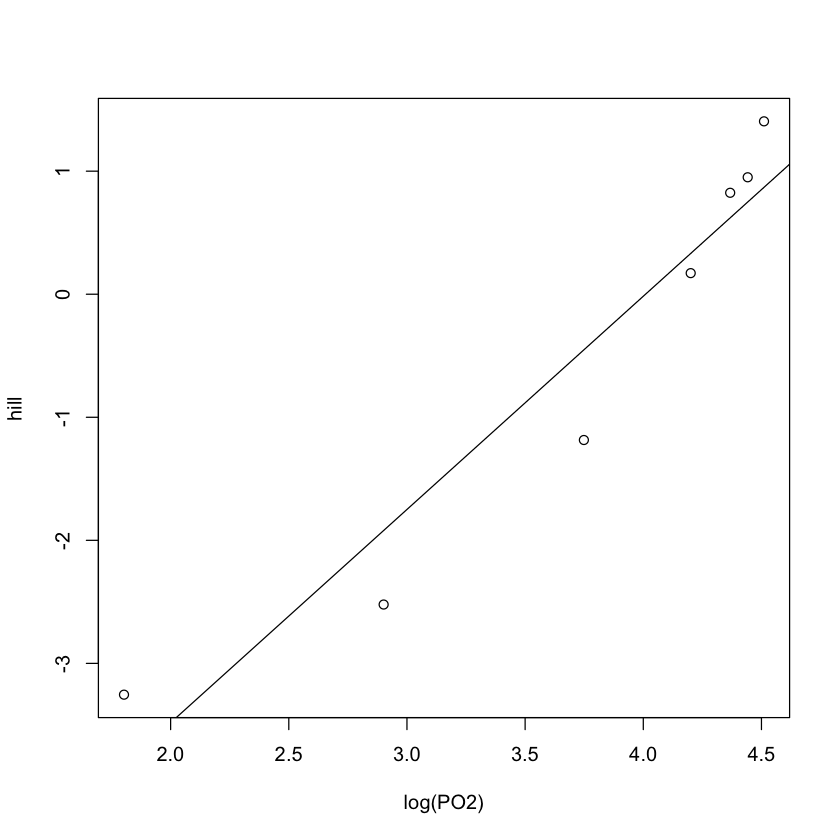

In [32]:
summary(lm(hill~log(PO2), data=hem_73))
plot(hill~log(PO2), data=hem_73)
abline(a = -6.948, b = 1.733)

3. Create a magnitude of Bohr Shift graph.

In [5]:
?glm

glm {stats},R Documentation
formula,"an object of class ""formula"" (or one that can be coerced to that class): a symbolic description of the model to be fitted. The details of model specification are given under ‘Details’."
family,"a description of the error distribution and link function to be used in the model. For glm this can be a character string naming a family function, a family function or the result of a call to a family function. For glm.fit only the third option is supported. (See family for details of family functions.)"
data,"an optional data frame, list or environment (or object coercible by as.data.frame to a data frame) containing the variables in the model. If not found in data, the variables are taken from environment(formula), typically the environment from which glm is called."
weights,an optional vector of ‘prior weights’ to be used in the fitting process. Should be NULL or a numeric vector.
subset,an optional vector specifying a subset of observations to be used in the fitting process.
na.action,"a function which indicates what should happen when the data contain NAs. The default is set by the na.action setting of options, and is na.fail if that is unset. The ‘factory-fresh’ default is na.omit. Another possible value is NULL, no action. Value na.exclude can be useful."
start,starting values for the parameters in the linear predictor.
etastart,starting values for the linear predictor.
mustart,starting values for the vector of means.
offset,"this can be used to specify an a priori known component to be included in the linear predictor during fitting. This should be NULL or a numeric vector of length equal to the number of cases. One or more offset terms can be included in the formula instead or as well, and if more than one is specified their sum is used. See model.offset."
